In [1]:
#%%
import pandas as pd
import numpy as np
import math 



In [2]:
#folder ="20230703_results/"
folder = "results/"

save_results = True

df_mca_results_1 = pd.read_csv("./raw_data/MCA_Results_Global_1.csv",delimiter =";")
df_mca_results_2 = pd.read_csv("./raw_data/MCA_Results_Global_2.csv",delimiter =";")

df_mca_results_1 = df_mca_results_1.loc[df_mca_results_1["Scenario"]=="2C_SSP2"]
df_mca_results_2 = df_mca_results_2.loc[df_mca_results_2["Scenario"]=="2C_SSP2"]


df_mca_results_1['Global Electricity Supply from Wind and Solar (EJ/yr.)'] = df_mca_results_1['Global Electricity Supply from Solar (EJ/yr.)'] + df_mca_results_1['Global Electricity Supply from Wind (EJ/yr.)']



In [3]:
categories = df_mca_results_1.columns[3:].to_list() + df_mca_results_2.columns[3:].to_list()
ranges = pd.DataFrame({"category":categories})
ranges["file"] = [1]*len(df_mca_results_1.columns[3:].to_list()) + [2]*len(df_mca_results_2.columns[3:].to_list())

min_2050 = [0]*len(categories)
max_2050 = [0]*len(categories)
min_2100 = [0]*len(categories)
max_2100 = [0]*len(categories)

for i in range(len(categories)):
    if float(ranges.loc[ranges["category"] == categories[i]]["file"]) == 1:
        df = df_mca_results_1
    else:
        df = df_mca_results_2
    
    min_2050[i] = df.loc[df["Years"] == 2050][categories[i]].min()
    max_2050[i] = df.loc[df["Years"] == 2050][categories[i]].max()
    min_2100[i] = df.loc[df["Years"] == 2100][categories[i]].min()
    max_2100[i] = df.loc[df["Years"] == 2100][categories[i]].max()

ranges["min 2050"] = min_2050
ranges["max_2050"] = max_2050
ranges["min_2100"] = min_2100
ranges["max_2100"] = max_2100

if save_results:
    ranges.to_csv(folder+"ranges.csv",sep=";")



clustering_categories_dict = { \
    #'Temperature change (oC)': 2050, \
 #'Marginal CO2 cost (USD/t)': 2100, \
 #'Global Electricity Supply from Wind and Solar (EJ/yr.)': 2100, \
 "Global Primary Energy Consumption of Renewable energy (EJ/yr.)":2100 , \
#  'Global Electricity Supply from Solar (EJ/yr.)': 2100, \
#  'Global Electricity Supply from Wind (EJ/yr.)': 2100, \
 'Global Primary Energy Consumption of Fossil Fuels (EJ/yr.)': 2100, \
 'Share of electricity consumption in industry worldwide': 2100, \
 'Share of electric residential heating in global energy service demand for heating': 2100, \
 #'Total  Global hydrogen supply (PJ/yr.)': 2100, \
 'Share of alternative fuels consumption in transport worldwide': 2100}
clustering_categories = [key + " in " + str(clustering_categories_dict[key]) for key in clustering_categories_dict.keys()]
headers = [df_mca_results_1.columns[2]] + clustering_categories


#data cleaning 
clean_monte_carlo_runs = []
for i in range(1000):
    clean = True
    for category in clustering_categories_dict.keys():
        if float(ranges.loc[ranges["category"] == category]["file"]) == 1:
            df = df_mca_results_1
        else:
            df = df_mca_results_2

        try:
            
            if math.isnan(df.loc[(df["Years"] == clustering_categories_dict[category]) & (df["Monte Carlo Experiment"] == i) ][category]):
                clean = False
        except:
            clean = False

    if clean:
        clean_monte_carlo_runs.append(i)
#print(str(len(clean_monte_carlo_runs)) + " clean Monte Carlo runs to consider")

# share_industry_2100 = []
# for i_cmcr in clean_monte_carlo_runs:
#     E_total = 1000 * float(df_mca_results_1['Global Total Primary Energy Consumption (EJ/yr.)']\
#                            .loc[(df_mca_results_1["Monte Carlo Experiment"] == i_cmcr) & \
#                                 (df_mca_results_1["Years"] == 2100)])
#     E_industry = float(df_mca_results_2['Global total final energy consumption in industry (PJ/yr.)']\
#                            .loc[(df_mca_results_2["Monte Carlo Experiment"] == i_cmcr) & \
#                                 (df_mca_results_2["Years"] == 2100)])
#     share_industry_2100 += [E_industry/E_total] 
# print("minimum share industry : " + str(float(min(share_industry_2100))))
# print("maximum share industry : " + str(float(max(share_industry_2100))))

key_metrics = pd.DataFrame({headers[0]:clean_monte_carlo_runs})
key_metrics.set_index(headers[0])


n_metrics = len(clustering_categories_dict)
n_clean_MC_runs = len(clean_monte_carlo_runs)
X = np.ndarray((n_clean_MC_runs,n_metrics))
max_metrics = np.ndarray((1,n_metrics))

for i in range(1,len(headers)):
    category = [k for k in clustering_categories_dict.keys()][i-1]
    #print(category)

    if float(ranges.loc[ranges["category"] == category]["file"]) == 1:
        df = df_mca_results_1
        #print(1)
    else:
        df = df_mca_results_2
        #print(2)

    # print(df.loc[df["Years"] == clustering_categories_dict[category]][category])

    key_metrics[headers[i]] = df.loc[(df["Years"] == clustering_categories_dict[category]) & (df["Monte Carlo Experiment"].isin(clean_monte_carlo_runs))][category].to_list()

    max_metrics[0,i-1] = df.loc[(df["Years"] == clustering_categories_dict[category]) & (df["Monte Carlo Experiment"].isin(clean_monte_carlo_runs))][category].max()

max_df = pd.DataFrame(max_metrics, columns = headers[1:],index=["max"])

if save_results:
    key_metrics.to_csv(folder+"key_metrics.csv",sep=";")

#we scale all metrics
idx_X = 0
for i_MC_run in clean_monte_carlo_runs:
    for j_metrics in range(0,n_metrics):
        
        X[idx_X,j_metrics] = key_metrics.loc[(key_metrics["Monte Carlo Experiment"]==i_MC_run)][headers[j_metrics+1]]/  \
            float(max_df[headers[j_metrics+1]])
    idx_X += 1
        # use long categorie names !!

df_input_normalized = pd.DataFrame(X, columns = headers[1:],index=clean_monte_carlo_runs)
if save_results:
    df_input_normalized.to_csv(folder+"df_input_normalized.csv",sep=";")

#%%

C:\Users\olive\AppData\Local\Temp\ipykernel_13128\1545569836.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if float(ranges.loc[ranges["category"] == categories[i]]["file"]) == 1:
C:\Users\olive\AppData\Local\Temp\ipykernel_13128\1545569836.py:52: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if float(ranges.loc[ranges["category"] == category]["file"]) == 1:
C:\Users\olive\AppData\Local\Temp\ipykernel_13128\1545569836.py:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(df.loc[(df["Years"] == clustering_categories_dict[category]) & (df["Monte Carlo Experiment"] == i) ][category]):
C:\Users\olive\AppData\Local\Temp\ipykernel_13128\1545569836.py:93: FutureWarning: Calling floa

	ReE	Fos	SEI	SEH	SAF	
2& 	0& 	0& 	1& 	0& 	0& 	\
3& 	0& 	0& 	1& 	1& 	0& 	\
4& 	0& 	0& 	2& 	1& 	0& 	\
5& 	0& 	0& 	2& 	2& 	0& 	\
6& 	0& 	1& 	2& 	2& 	0& 	\
7& 	0& 	2& 	2& 	2& 	0& 	\
8& 	1& 	2& 	2& 	2& 	0& 	\
9& 	0& 	3& 	2& 	3& 	0& 	\
10& 	0& 	3& 	2& 	3& 	1& 	\
11& 	1& 	3& 	2& 	3& 	1& 	\
12& 	1& 	3& 	3& 	3& 	1& 	\
13& 	1& 	5& 	3& 	3& 	0& 	\
14& 	2& 	5& 	3& 	3& 	0& 	\
15& 	1& 	6& 	3& 	3& 	1& 	\
16& 	1& 	7& 	3& 	3& 	1& 	\
17& 	2& 	7& 	3& 	4& 	0& 	\
18& 	2& 	7& 	4& 	4& 	0& 	\
19& 	2& 	8& 	3& 	5& 	0& 	\
20& 	2& 	7& 	4& 	5& 	1& 	\
21& 	1& 	9& 	4& 	5& 	1& 	\
22& 	2& 	9& 	3& 	7& 	0& 	\
23& 	1& 	10& 	5& 	5& 	1& 	\
24& 	2& 	12& 	3& 	5& 	1& 	\


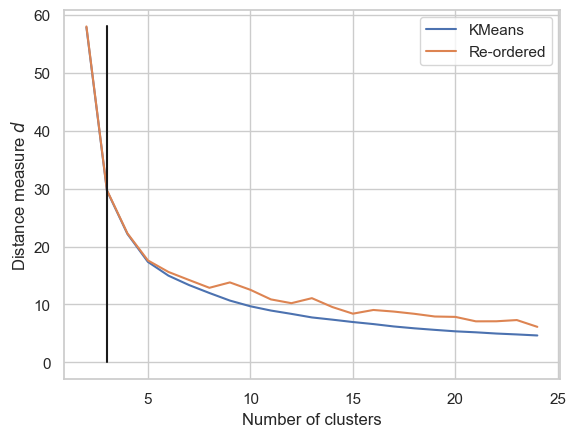

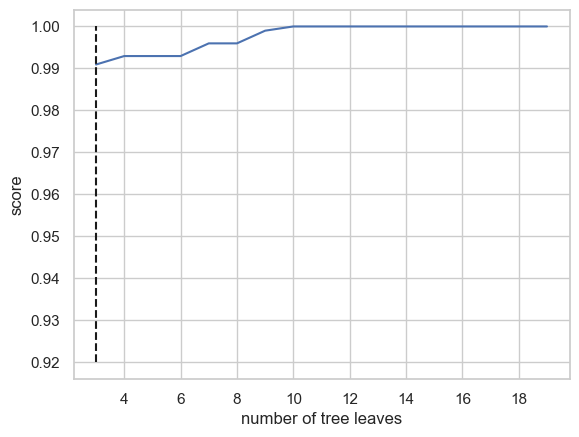

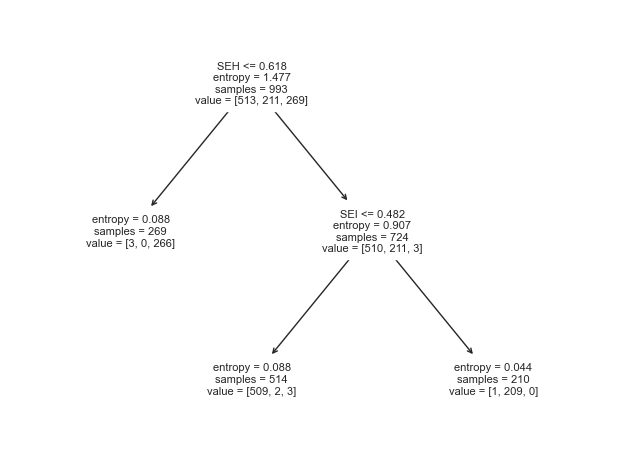

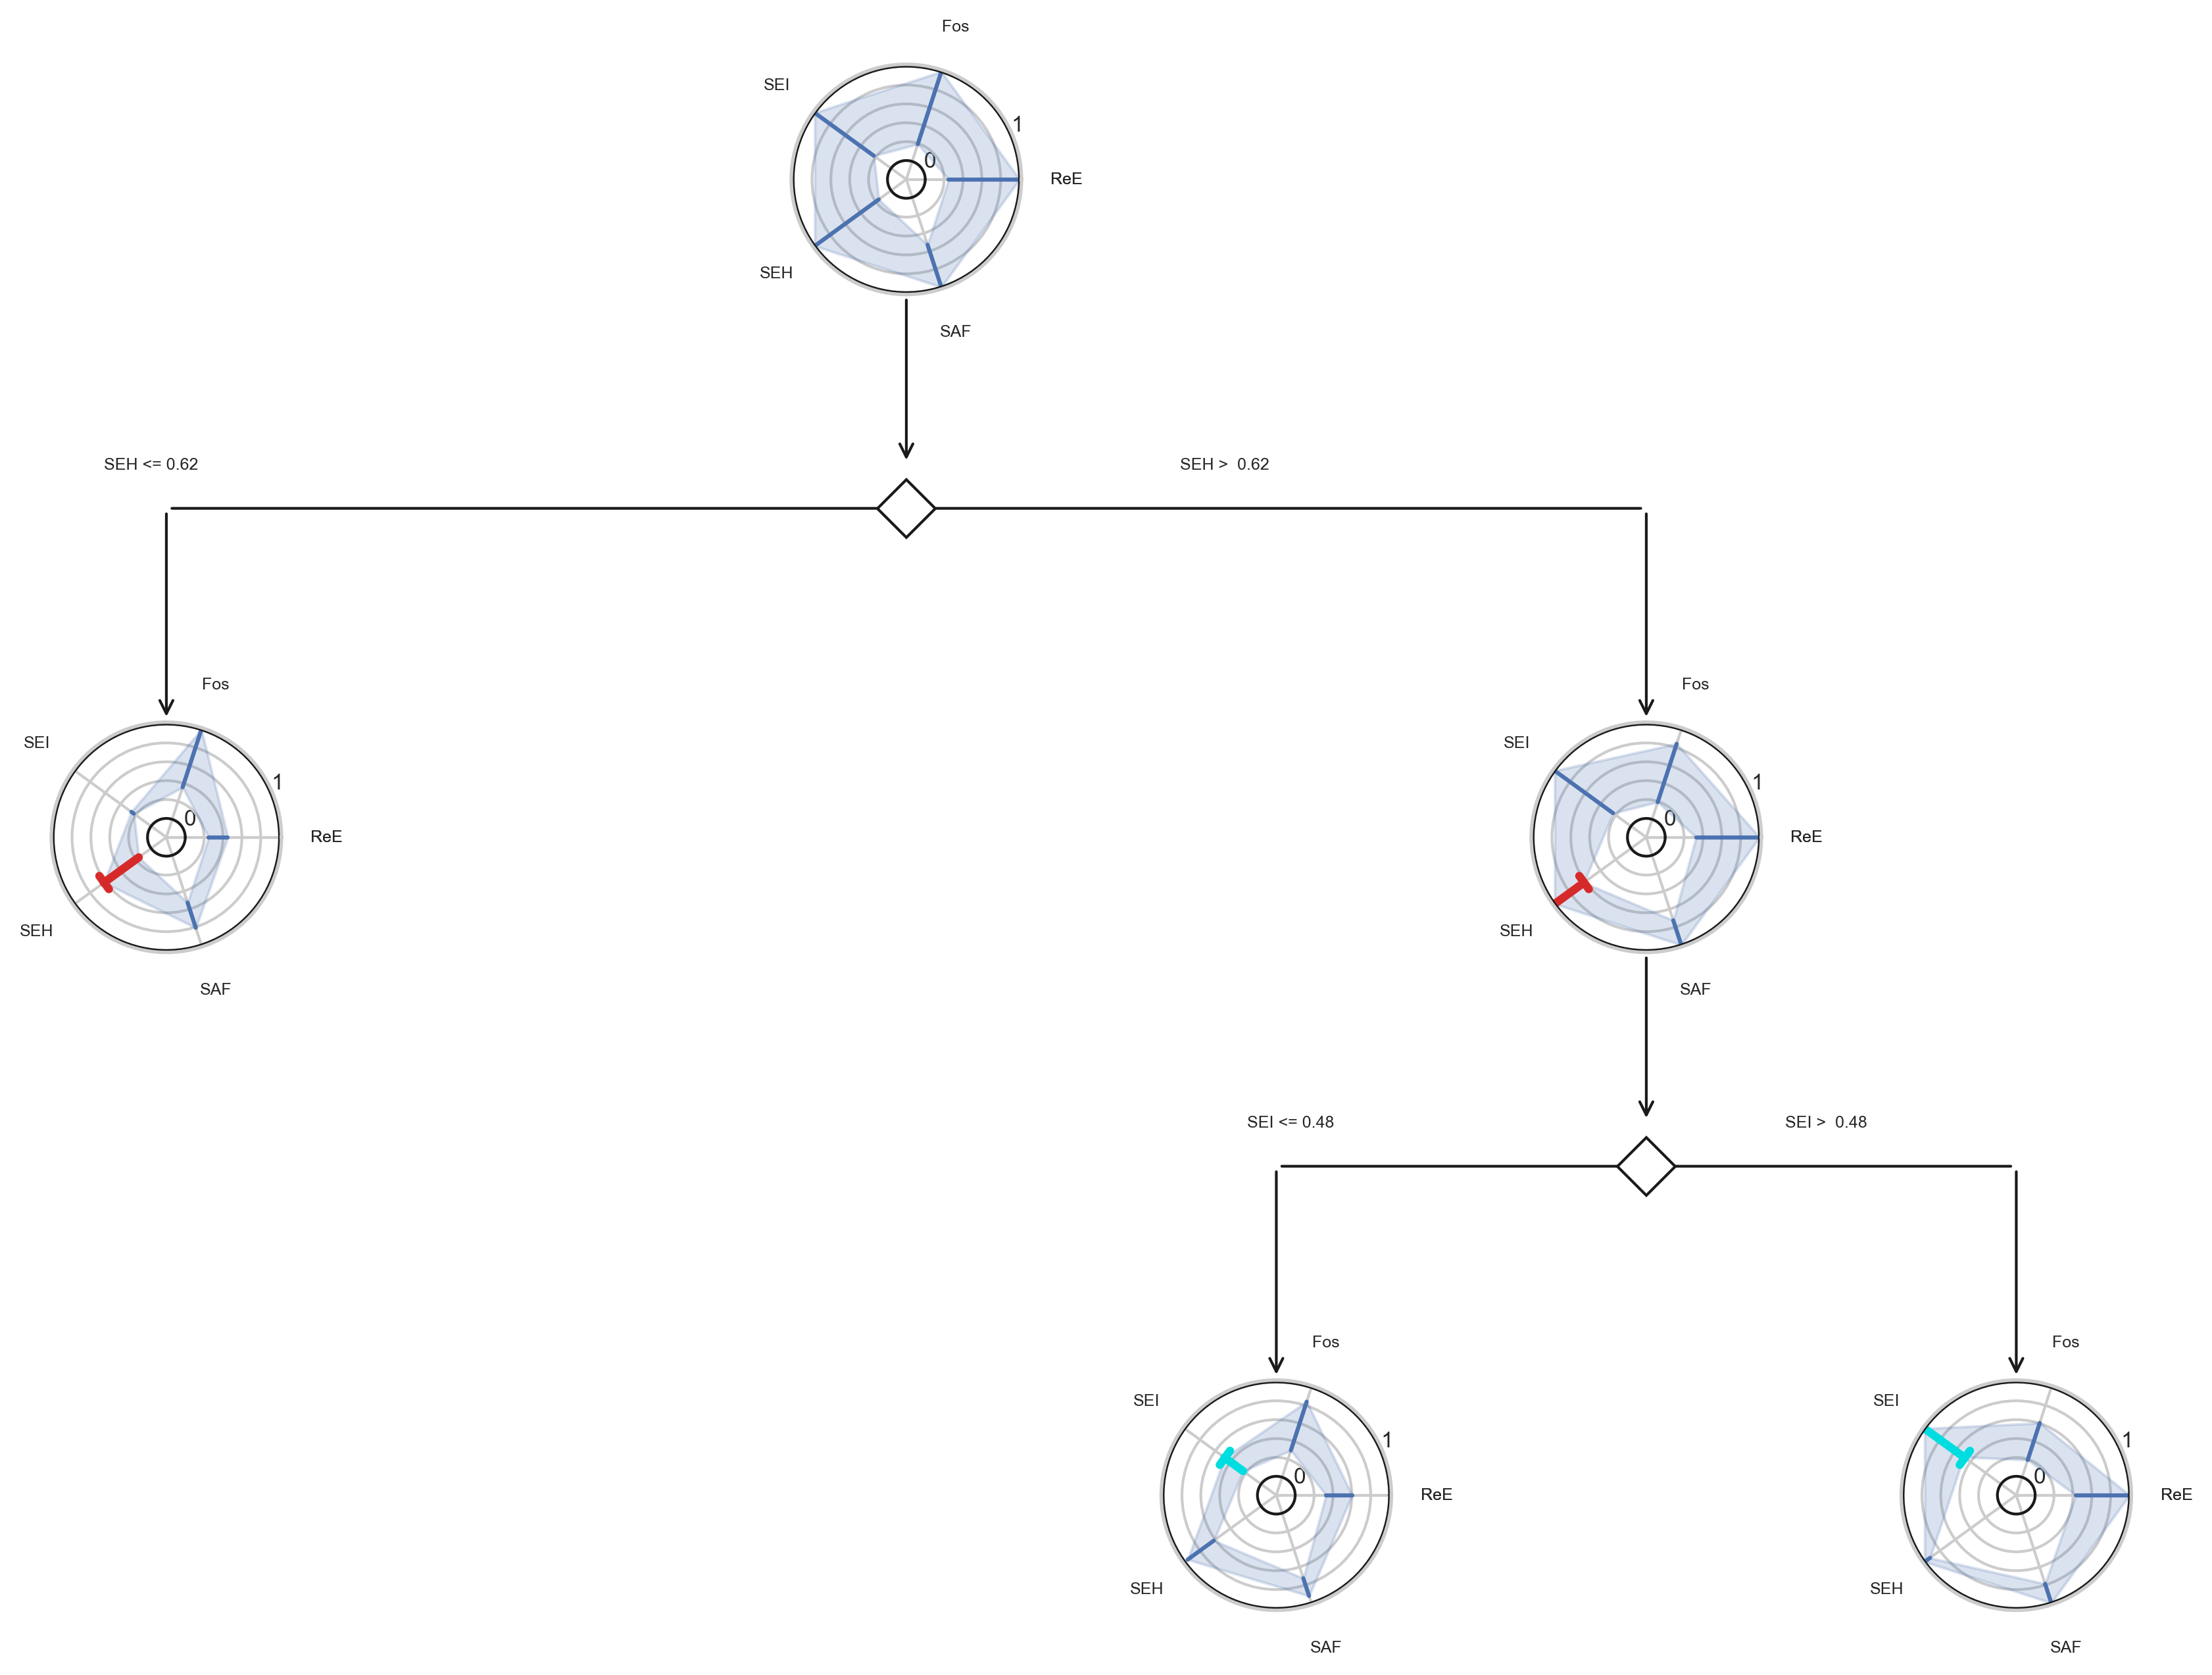

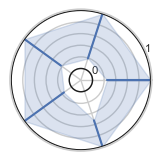

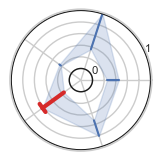

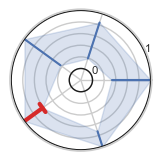

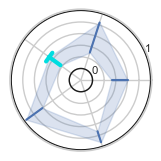

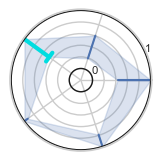

In [5]:
#%%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import sys
import copy
sys.path.append('..')
from utilities.produce_interpretable_tree import produce_interpretable_tree
#%%
# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'qt')
seaborn.set(style = 'whitegrid')  

n_cl = 3
short_names = [
 'ReE',
 'Fos',
 'SEI',
 'SEH',
 'SAF']
folder = "results/"
save_results = True

df_input = pd.read_csv(folder+"df_input_normalized.csv",sep=";")
df_input = df_input.set_index("Unnamed: 0")


#%%
colors=["b","c",(0/255,221/255,224/255),(214/255,42/255,42/255),"m"]
df_input_with_final_cluster , nodes, choices, decision_space = \
    produce_interpretable_tree(df_input, short_names,n_cl,colors=colors)


#%%
if save_results:
    df_input_with_final_cluster.to_csv(folder+"df_input_with_final_cluster.csv", sep = ";")

# %%


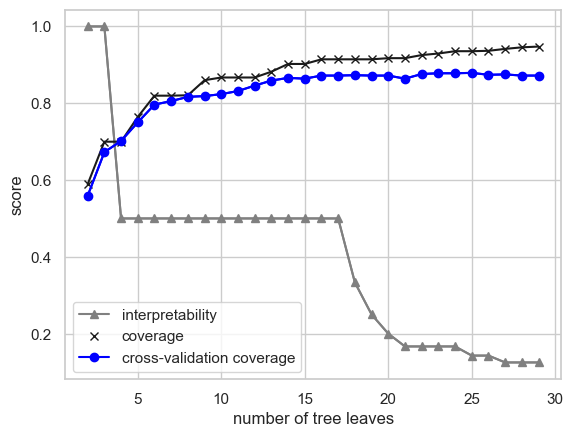

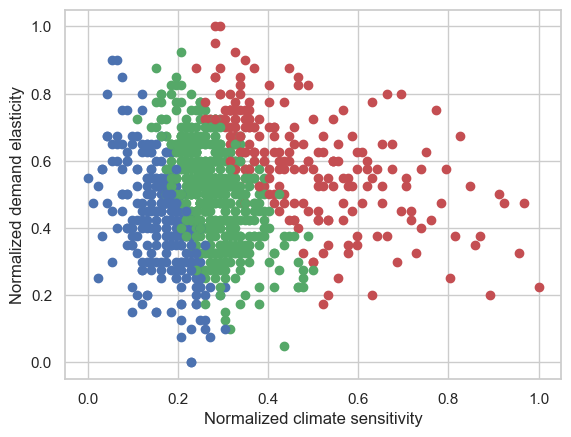

In [6]:
#%%
from sklearn.tree import export_text
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn
import copy

#from IPython import get_ipython
#get_ipython().run_line_magic('matplotlib', 'qt')
seaborn.set(style = 'whitegrid')  

#%%
folder = "results/"
df_input_with_final_cluster = pd.read_csv(folder + "df_input_with_final_cluster.csv",delimiter=";")
df_input_with_final_cluster = df_input_with_final_cluster.set_index("Unnamed: 0")

n_cl = df_input_with_final_cluster["cluster_final"].max() + 1
categories = df_input_with_final_cluster.columns.to_list() 
categories.remove("cluster_final")
categories.remove("initial cluster")
n_metrics = len(categories)


MC_inputs = pd.read_csv("./raw_data/MCA_inputs.csv",delimiter=";")
clean_runs = df_input_with_final_cluster.index
MC_inputs = MC_inputs.loc[MC_inputs["Monte Carlo Experiment"].isin(clean_runs)]
MC_inputs.set_index("Monte Carlo Experiment")
MC_inputs["cluster_final"] = df_input_with_final_cluster["cluster_final"].to_list()
inputs = [ 'GDP', 'Population', \
       'Other Energy Service Demand Drivers', 'Social discount rate', \
       'Elasticity of energy service demand to its own driver', \
       'Elasticity of energy service demand to its own price', \
       'CO2 Storage Potential', 'Wind Potential','Solar Potential', \
       'Biomass Potential', 'Oil & Gas Potential', 'Solar PV  Investment Cost', \
       'Wind Investment Cost', 'Bioenergy with CCS Specific Investment Cost', \
       'Other technologies costs', 'Forcing of non-energy emissions', \
       'Land Use, Land Use Change and Forestry Sinks', \
       'Climate Sensitivity (in oC)']
#%%
target_tree = df_input_with_final_cluster["cluster_final"]
n_leafnodes = [i for i in range(2,30)]
coverage = [0]*len(n_leafnodes)
cross_validation_coverage = [0]*len(n_leafnodes)
interpretability  = [0]*len(n_leafnodes)
n_variables = [0]*len(n_leafnodes)
N_cross_validation = 10
i_score = 0

k = 5  # Number of folds (you can change this as needed)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for n_leafs in n_leafnodes:
    explanation_tree = tree.DecisionTreeClassifier(max_leaf_nodes=n_leafs,criterion="entropy")
    explanation_tree.fit(MC_inputs[inputs],target_tree)
    coverage[i_score] = explanation_tree.score(MC_inputs[inputs],target_tree)
    tree_as_text = export_text(explanation_tree,feature_names=inputs)
    n_variables[i_score] = sum([tree_as_text.__contains__(input_i) \
                                for input_i in inputs])
    interpretability[i_score] = 1/n_variables[i_score]
    coverage_cv_sum = 0
    for train_indices, test_indices in kf.split(clean_runs):
        MC_train = MC_inputs[inputs].loc[MC_inputs[inputs].index.isin([clean_runs[i]-1 for i in train_indices])]
        MC_test = MC_inputs[inputs].loc[MC_inputs[inputs].index.isin([clean_runs[i]-1 for i in test_indices])]
        target_tree_train = target_tree.loc[target_tree.index.isin([clean_runs[i] for i in train_indices])]
        target_tree_test = target_tree.loc[target_tree.index.isin([clean_runs[i] for i in test_indices])]
        explanation_tree.fit(MC_train,target_tree_train)
        coverage_cv_sum += explanation_tree.score(MC_test,target_tree_test)
    cross_validation_coverage[i_score] = coverage_cv_sum/k
    i_score += 1


#%%
plt.figure()
plt.plot(n_leafnodes,interpretability,marker="^",label="interpretability",color="gray")
plt.plot(n_leafnodes,interpretability,color="gray") 
plt.plot(n_leafnodes,coverage,"x",label="coverage",color="k")
plt.plot(n_leafnodes,coverage,color="k")  
plt.plot(n_leafnodes,cross_validation_coverage,marker="o",label="cross-validation coverage",color="blue")
plt.plot(n_leafnodes,cross_validation_coverage,color="blue")   
plt.xlabel("number of tree leaves")
plt.ylabel("score")
plt.legend()
#%%
plt.savefig("figures/sensitivity_n_leaves.svg")
plt.savefig("figures/sensitivity_n_leaves.pdf")
#%%
MC_inputs_normalized = copy.deepcopy(MC_inputs)
for cat in inputs:
    MC_inputs_normalized[cat] = MC_inputs_normalized[cat] - MC_inputs_normalized[cat].min()
    MC_inputs_normalized[cat] = MC_inputs_normalized[cat]/MC_inputs_normalized[cat].max()



colors=["g","r","b","magenta"]
plt.figure()
for i in clean_runs:
    plt.plot(MC_inputs_normalized['Climate Sensitivity (in oC)'][i-1], \
             MC_inputs_normalized['Elasticity of energy service demand to its own driver'][i-1],"o", \
                color=colors[MC_inputs_normalized["cluster_final"][i-1]])
plt.xlabel('Normalized climate sensitivity')
plt.ylabel('Normalized demand elasticity')
plt.savefig("figures/explanation.svg")
plt.savefig("figures/explanation.pdf")
# %%
